TAREA 1: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc.

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

In [1]:
# Módulos necesarios
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Relación de diámetros de monedas en milímetros
# Los valores de diámetro en mm para las monedas europeas comunes
coin_diameters = {
    16.25: 0.01,  # 1 céntimo
    18.75: 0.02,  # 2 céntimos
    21.25: 0.05,  # 5 céntimos
    19.75: 0.10,  # 10 céntimos
    22.25: 0.20,  # 20 céntimos
    24.25: 0.50,  # 50 céntimos
    23.25: 1.00,  # 1 euro
    25.75: 2.00   # 2 euros
}

# Función para encontrar el valor de una moneda según su diámetro en milímetros
def get_coin_value(diameter):
    # Buscar la moneda más cercana según su diámetro
    closest_diameter = min(coin_diameters.keys(), key=lambda x: abs(x - diameter))
    return coin_diameters[closest_diameter]

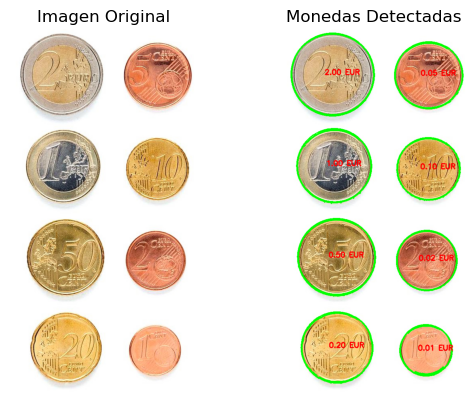

Valor total de las monedas: 3.88 EUR


In [11]:
# Cargar la imagen
image_path = './assets/Monedas.jpg'
image = cv2.imread(image_path)

# Preprocesar la imagen
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Dos variantes de umbralizado. Probar otros parámetros, aplicar filtro previo, etc.
umbral = 200 # Prueba varios comenzando en 130
# Umbralizado binario invertido, dado que por defecto se asume objetos en blanco
th1,img_th1 = cv2.threshold(gray,umbral,255,cv2.THRESH_BINARY_INV)

# Localiza contornos en la imagen
contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

# Dibuja sobre la imagen original
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

# Imagen negra para contornos rellenos
img_cont = np.zeros(img_rgb.shape)

total_value = 0

# Suponemos que el mayor contorno encontrado corresponde a una moneda de 2 euros
# y la usaremos como referencia para calcular la escala de píxeles a milímetros.
max_radio_px = 0

# Recorrer los contornos externos
for c in contornos2:
    area = cv2.contourArea(c)
    if area > 10:  # Filtrar áreas pequeñas
        # Mínimo círculo que contiene el contorno
        (cx, cy), radio = cv2.minEnclosingCircle(c)
        
        # Actualizar el mayor radio detectado
        if radio > max_radio_px:
            max_radio_px = radio

# Establecer la escala para convertir el radio en píxeles a milímetros
if max_radio_px > 0:
    reference_diameter_mm = 25.75  # Diámetro de 2 euros en mm
    scale = reference_diameter_mm / (2 * max_radio_px)

# Recorremos los contornos nuevamente para clasificar las monedas
for c in contornos2:
    area = cv2.contourArea(c)
    if area > 10:
        # Mínimo círculo que contiene el contorno
        (cx, cy), radio = cv2.minEnclosingCircle(c)
        
        # Convertir el radio de píxeles a milímetros
        coin_diameter_mm = 2 * radio * scale
        
        # Obtener el valor de la moneda según su diámetro
        coin_value = get_coin_value(coin_diameter_mm)
        total_value += coin_value
        
        # Dibujar el círculo y el valor en la imagen
        cv2.circle(img_rgb, (int(cx), int(cy)), int(radio), (0, 255, 0), 2)
        cv2.putText(img_rgb, f"{coin_value:.2f} EUR", (int(cx) - 20, int(cy)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Mostrar los resultados
plt.subplot(121)
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
plt.title('Imagen Original')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Monedas Detectadas')

plt.show()

# Imprimir el valor total
print(f"Valor total de las monedas: {total_value:.2f} EUR")